<a href="https://colab.research.google.com/github/NomaguguTNdlovu/repo-2025_ia651_ndlov/blob/main/CCE_Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Step 1: Upload the File
from google.colab import files
uploaded = files.upload()

Saving RM2502.H03 to RM2502 (5).H03


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
# STEP 3: Load the uploaded file (get filename automatically)
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename, encoding='utf-16', skip_blank_lines=True)

In [ ]:

# STEP 4: Fix malformed time format like "00:00:15:27"
def clean_time_str(time_str):
    parts = str(time_str).split(':')
    if len(parts) == 4:
        return f"{parts[1]}:{parts[2]}:{parts[3]}"
    return time_str  # fallback

df['CleanTime'] = df['Time'].astype(str).apply(clean_time_str)


In [ ]:
# STEP 5: Combine date and cleaned time into proper datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['CleanTime'], errors='coerce')
df = df.dropna(subset=['Datetime'])


In [ ]:
# STEP 6: Extract and process TC11 temperature
df_tc11 = df[['Datetime', 'PAC:TC11_AVG']].copy()
df_tc11.rename(columns={'PAC:TC11_AVG': 'TC11'}, inplace=True)
df_tc11['Date'] = df_tc11['Datetime'].dt.date
daily_avg_raw = df_tc11.groupby('Date')['TC11'].mean().reset_index()


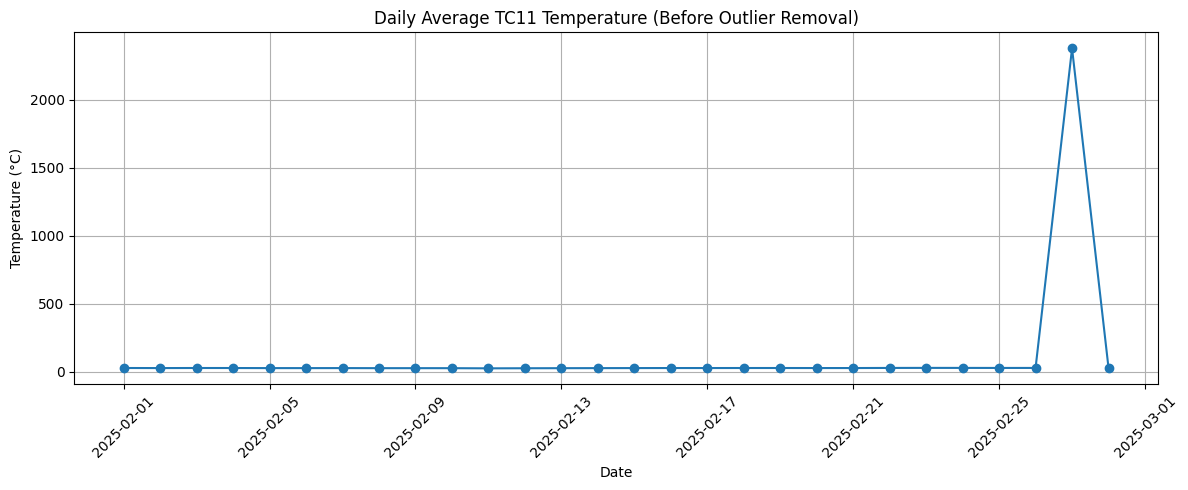

In [ ]:
# STEP 7: Plot daily temperature trend (before outlier removal)
plt.figure(figsize=(12, 5))
plt.plot(daily_avg_raw['Date'], daily_avg_raw['TC11'], marker='o')
plt.title('Daily Average TC11 Temperature (Before Outlier Removal)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# STEP 8: Outlier removal using IQR method
Q1 = daily_avg_raw['TC11'].quantile(0.25)
Q3 = daily_avg_raw['TC11'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

daily_avg_clean = daily_avg_raw[
    (daily_avg_raw['TC11'] >= lower_bound) &
    (daily_avg_raw['TC11'] <= upper_bound)
]

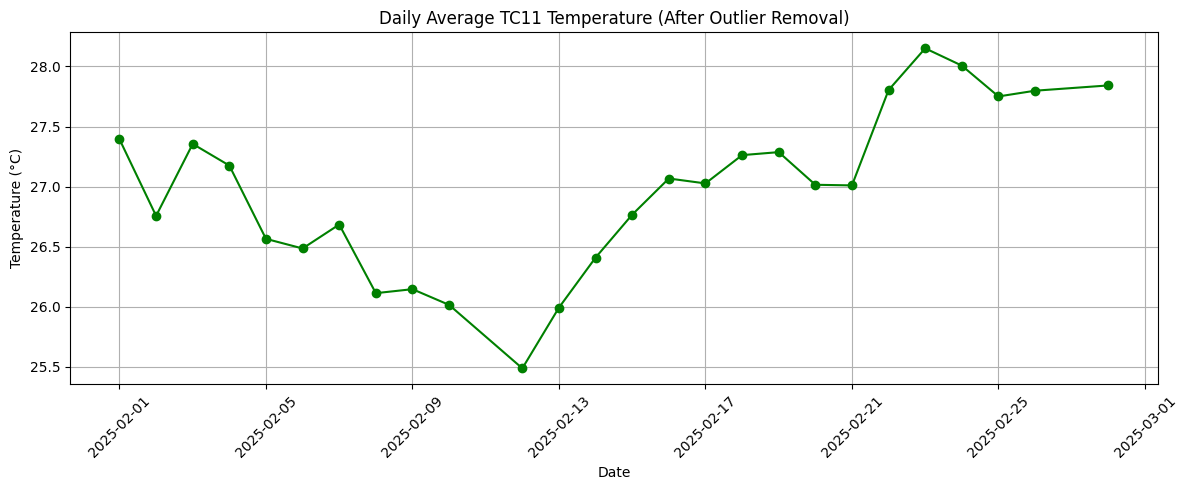

In [ ]:
# STEP 9: Plot daily trend (after outlier removal)
plt.figure(figsize=(12, 5))
plt.plot(daily_avg_clean['Date'], daily_avg_clean['TC11'], marker='o', color='green')
plt.title('Daily Average TC11 Temperature (After Outlier Removal)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
# ✅ Upload both November and December files
uploaded = files.upload()
uploaded_files = list(uploaded.keys())
df_nov = pd.read_csv(uploaded_files[0], encoding='utf-16', skip_blank_lines=True)
df_dec = pd.read_csv(uploaded_files[1], encoding='utf-16', skip_blank_lines=True)

Saving RM2411.H05 to RM2411 (3).H05
Saving RM2412.H05 to RM2412 (1).H05


In [ ]:
# ✅ Clean and parse datetime
def clean_time_str(time_str):
    parts = str(time_str).split(':')
    return f"{parts[1]}:{parts[2]}:{parts[3]}" if len(parts) == 4 else time_str

In [ ]:
for df in [df_nov, df_dec]:
    df['CleanTime'] = df['Time'].astype(str).apply(clean_time_str)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['CleanTime'], errors='coerce')

/tmp/ipython-input-89-4003575570.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['CleanTime'], errors='coerce')
/tmp/ipython-input-89-4003575570.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['CleanTime'], errors='coerce')


In [ ]:
# ✅ Merge and sort
df = pd.concat([df_nov, df_dec], ignore_index=True)
df = df.dropna(subset=['Datetime']).sort_values('Datetime').reset_index(drop=True)

In [ ]:
# ✅ Extract last daily values
df['DateOnly'] = pd.to_datetime(df['Datetime'].dt.date)
df_daily = df.groupby('DateOnly').last().reset_index()

In [ ]:
# ✅ Create full daily range and forward fill
full_range = pd.date_range(start=df_daily['DateOnly'].min(), end=df_daily['DateOnly'].max(), freq='D')
df_filled = pd.DataFrame({'DateOnly': full_range})
df_filled = df_filled.merge(df_daily[['DateOnly', 'PAC:Meth_total', 'PAC:Prop_total']], on='DateOnly', how='left')
df_filled['PAC:Meth_total'] = df_filled['PAC:Meth_total'].ffill()
df_filled['PAC:Prop_total'] = df_filled['PAC:Prop_total'].ffill()

In [ ]:
# ✅ Correction function
def correct_cumulative_by_deltas(series):
    corrected = [series.iloc[0]]
    for i in range(1, len(series)):
        prev, curr = series.iloc[i - 1], series.iloc[i]
        delta = curr - prev if curr >= prev else 0
        corrected.append(corrected[-1] + delta)
    return corrected

In [ ]:
# ✅ Apply correction
df_filled['Meth_Corrected'] = correct_cumulative_by_deltas(df_filled['PAC:Meth_total'])
df_filled['Prop_Corrected'] = correct_cumulative_by_deltas(df_filled['PAC:Prop_total'])

In [ ]:
# ✅ Reset points
meth_resets = df_filled['DateOnly'][df_filled['PAC:Meth_total'].diff() < 0].tolist()
prop_resets = df_filled['DateOnly'][df_filled['PAC:Prop_total'].diff() < 0].tolist()

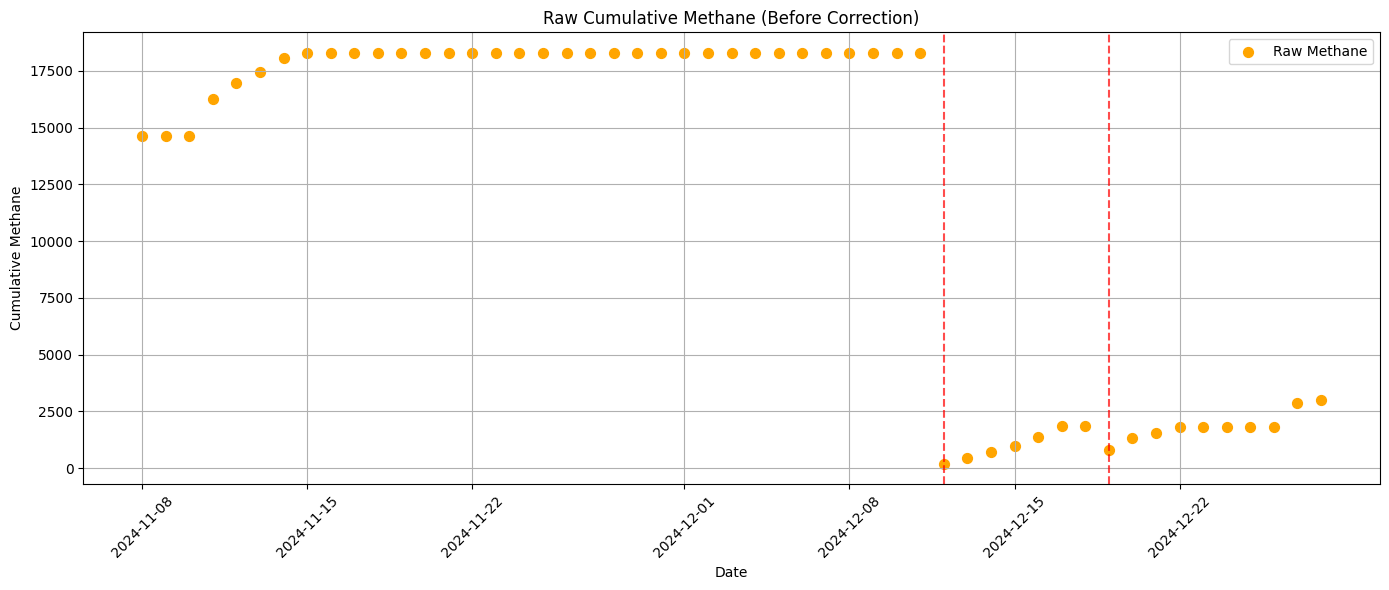

In [ ]:
# ✅ Plot - Methane Raw
plt.figure(figsize=(14, 6))
plt.scatter(df_filled['DateOnly'], df_filled['PAC:Meth_total'], label='Raw Methane', color='orange', s=50)
for reset in meth_resets:
    plt.axvline(reset, color='red', linestyle='--', alpha=0.7)
plt.title("Raw Cumulative Methane (Before Correction)")
plt.xlabel("Date")
plt.ylabel("Cumulative Methane")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

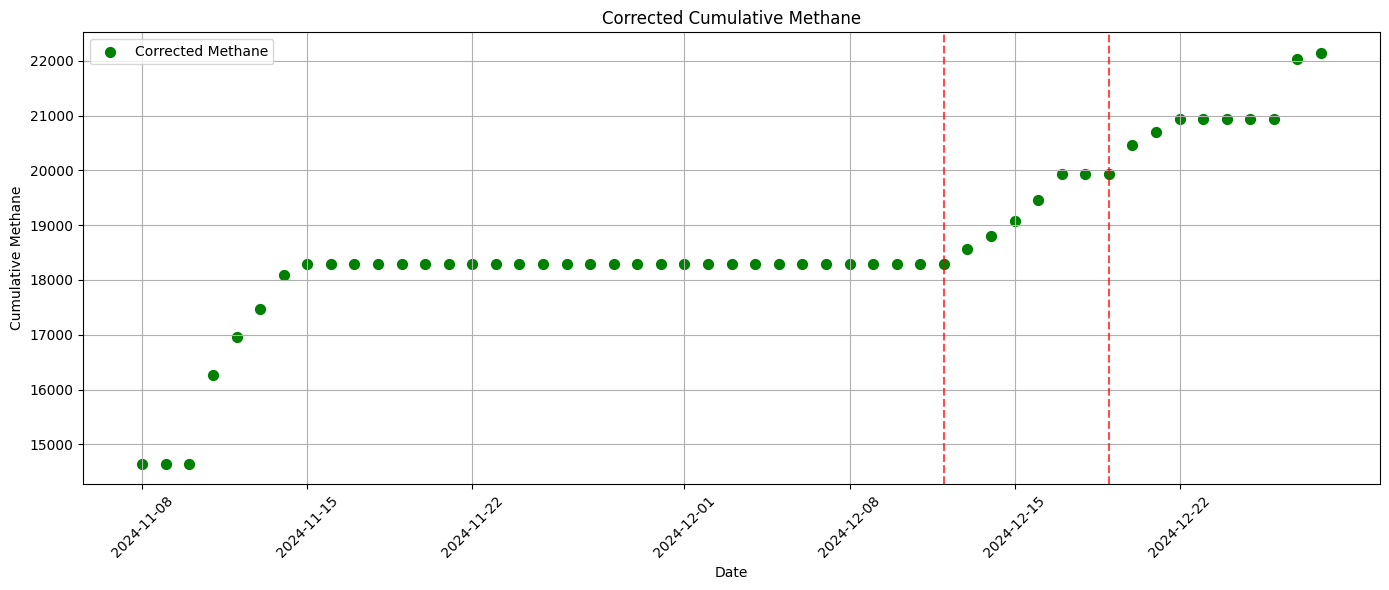

In [ ]:
# ✅ Plot - Methane Corrected
plt.figure(figsize=(14, 6))
plt.scatter(df_filled['DateOnly'], df_filled['Meth_Corrected'], label='Corrected Methane', color='green', s=50)
for reset in meth_resets:
    plt.axvline(reset, color='red', linestyle='--', alpha=0.7)
plt.title("Corrected Cumulative Methane")
plt.xlabel("Date")
plt.ylabel("Cumulative Methane")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

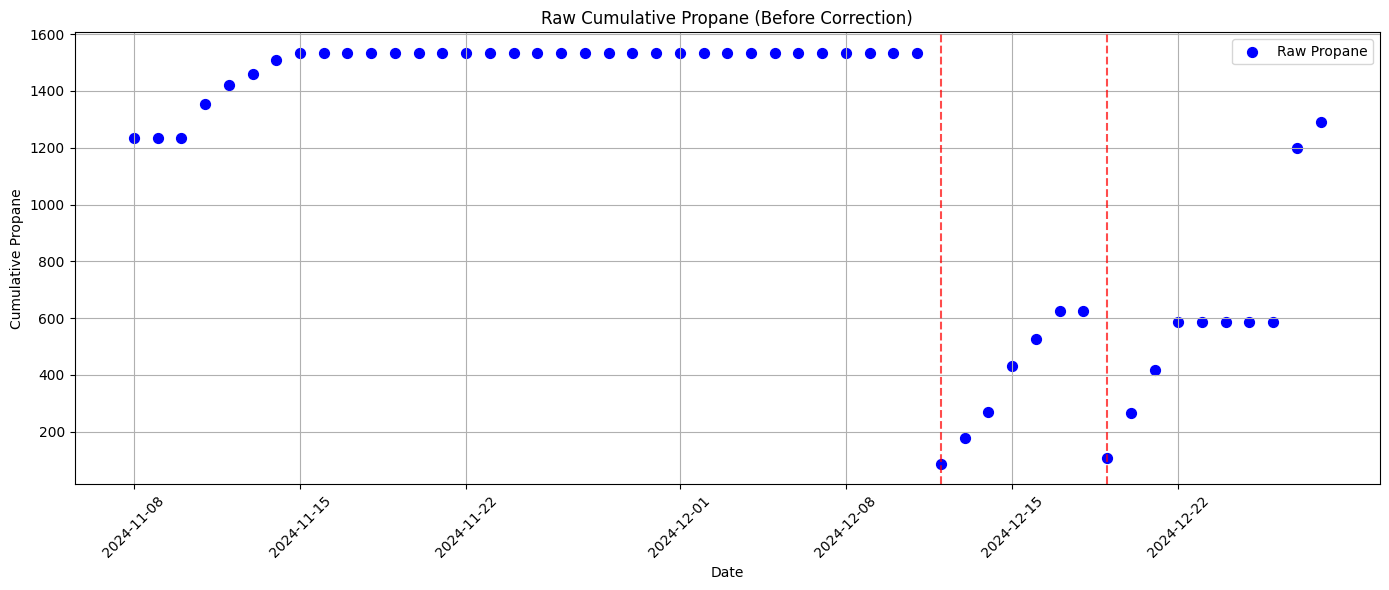

In [ ]:
# ✅ Plot - Propane Raw
plt.figure(figsize=(14, 6))
plt.scatter(df_filled['DateOnly'], df_filled['PAC:Prop_total'], label='Raw Propane', color='blue', s=50)
for reset in prop_resets:
    plt.axvline(reset, color='red', linestyle='--', alpha=0.7)
plt.title("Raw Cumulative Propane (Before Correction)")
plt.xlabel("Date")
plt.ylabel("Cumulative Propane")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

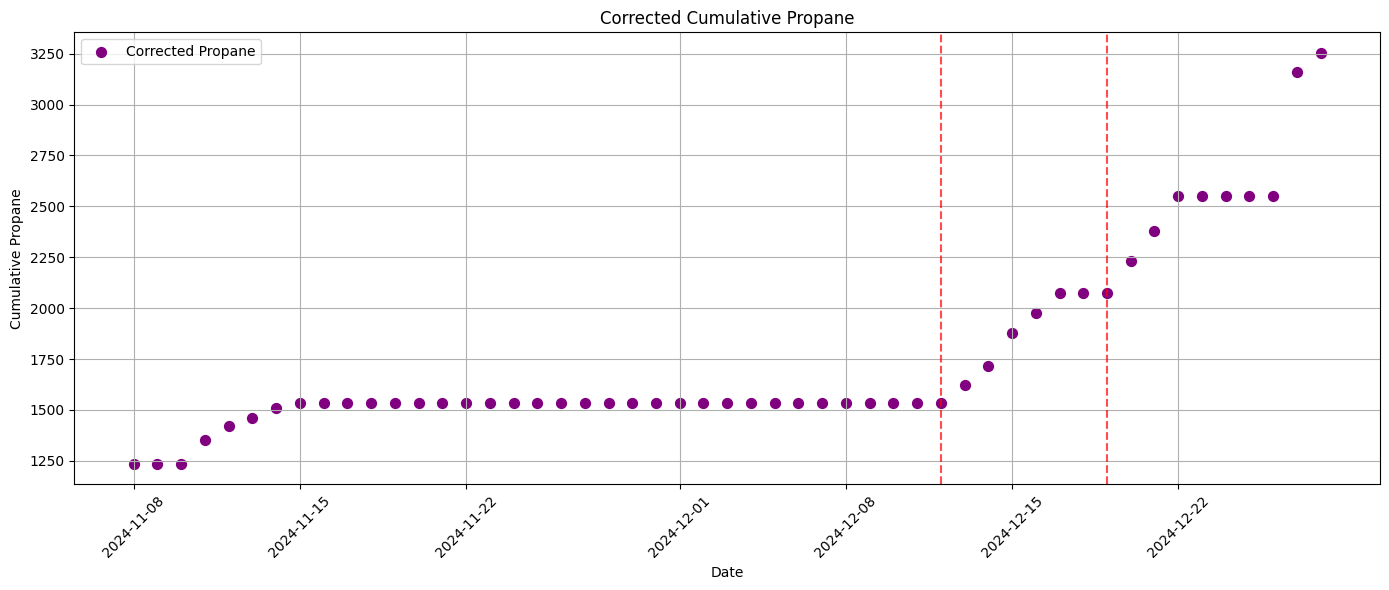

In [ ]:
# ✅ Plot - Propane Corrected
plt.figure(figsize=(14, 6))
plt.scatter(df_filled['DateOnly'], df_filled['Prop_Corrected'], label='Corrected Propane', color='purple', s=50)
for reset in prop_resets:
    plt.axvline(reset, color='red', linestyle='--', alpha=0.7)
plt.title("Corrected Cumulative Propane")
plt.xlabel("Date")
plt.ylabel("Cumulative Propane")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()